In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q ogb>=1.3.0

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

from ipywidgets import interact, interact_manual
import pandas as pd

# Periodic table thanks to Chris Andrejewski <christopher.andrejewski@gmail.com>
link = "https://raw.githubusercontent.com/andrejewski/periodic-table/master/data.csv"
elements = pd.read_csv(link, index_col=0, sep=", ", engine="python")

     |████████████████████████████████| 2.6MB 5.0MB/s 
     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 235kB 6.6MB/s 
     |████████████████████████████████| 2.2MB 7.8MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 


# Molecules classification

## The dataset

We study the [`ogbg-molhiv` dataset][1].
Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not.

## The task

We want to predict whether a molecule inhibits HIV virus replication or not, as accurately as possible,

[1]: https://ogb.stanford.edu/docs/graphprop/

## Data Loading

In [54]:
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = elements.loc[graph.x[:,0] + 1, "symbol"].values
        
        return graph


In [55]:
from torch.nn.functional import one_hot

class OneHot(object):
    """ 
    Takes LongTensor with index values of shape (*) and returns a tensor of shape
    (*, num_classes) that have zeros everywhere except where the index of last
    dimension matches the corresponding value of the input tensor, in which case
    it will be 1.
    """
    def __init__(self, column=0, num_classes=-1):
        self.column = column
        self.num_classes = num_classes

    def __call__(self, graph):
        enc = one_hot(
            graph.x[:, self.column],
            num_classes=self.num_classes
        )

        x = torch.empty(
            (enc.shape[0], atoms.shape[1] + graph.x.shape[1] - 1)
        )
    
        x[:, :self.column] = graph.x[:, :self.column]
        x[:, self.column:(self.column + enc.shape[1])] = enc
        x[:, (self.column + enc.shape[1]):] = graph.x[:, (self.column + 1):]
        graph.x = x

        return graph

    def __repr__(self):
        return f"OneHot(self.column={self.self.column}, num_classes={self.num_classes})"

In [56]:
# IMPORTS
from ogb.graphproppred import PygGraphPropPredDataset # Dataset package
from torch_geometric.data import DataLoader # Utility to load data
from torch_geometric.transforms import Compose

In [57]:
# Download and process data at './dataset/ogbg_molhiv/'
dataset = PygGraphPropPredDataset(
    name = "ogbg-molhiv", root = '.',
    transform=Compose([
        AddSymbols(),
        OneHot(column=0,num_classes=118),
    ])
)

### Features

From the [doc](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py).

**Atom** (node) features:
- atomic_num : cat (118 vals)
- chirality : cat (4 vals)
- degree : int (0 to 10)
- formal_charge : int (-5 to 5)
- numH : int (0 to 8)
- number_radical_e : int (0 to 4)
- possible hybridization : cat (5 vals)
- is_aromatic : bool
- is_in_ring : bool

**Bond** (edge) features:
- bond_type : cat (4 vals)
- bond_stereo : cat (6 vals)
- is_conjugated : bool

In [58]:
el0 = dataset[0]
print(f"""
First element : {el0}

Attributes : 
    - Node features : {el0.num_node_features}
    - Edge features : {el0.num_edge_features}
""")


First element : Data(edge_attr=[40, 3], edge_index=[2, 40], symbols=['C ' 'C ' 'C ' 'O ' 'Cu ' 'O ' 'C ' 'C ' 'C ' 'C ' 'O ' 'C ' 'C ' 'C '
 'C ' 'C ' 'C ' 'C ' 'O '], x=[19, 126], y=[1, 1])

Attributes : 
    - Node features : 126
    - Edge features : 3



In [62]:
import numpy as np

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)

In [64]:
print(f"Unique: {len(np.unique(all_atoms))}")
print(np.unique(all_atoms))

Unique: 55
['Ac ' 'Ag ' 'Al ' 'As ' 'Au ' 'B ' 'Bi ' 'Br ' 'C ' 'Ca ' 'Cl ' 'Co '
 'Cr ' 'Cs ' 'Cu ' 'F ' 'Fe ' 'Ga ' 'Gd ' 'Ge ' 'H ' 'Hg ' 'Ho ' 'I '
 'Ir ' 'K ' 'Li ' 'Mg ' 'Mn ' 'Mo ' 'N ' 'Na ' 'Ni ' 'O ' 'P ' 'Pb ' 'Pd '
 'Pt ' 'Re ' 'Rh ' 'Ru ' 'S ' 'Sb ' 'Se ' 'Si ' 'Sn ' 'Tb ' 'Te ' 'Ti '
 'Tl ' 'U ' 'V ' 'W ' 'Zn ' 'Zr ']


In [65]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

_el0 = dataset[0]  # Get the first graph object.

print()
print(_el0)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {_el0.num_nodes}')
print(f'Number of edges: {_el0.num_edges}')
print(f'Average node degree: {_el0.num_edges / _el0.num_nodes:.2f}')
print(f'Contains isolated nodes: {_el0.contains_isolated_nodes()}')
print(f'Contains self-loops: {_el0.contains_self_loops()}')
print(f'Is undirected: {_el0.is_undirected()}')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 126
Number of classes: 2

Data(edge_attr=[40, 3], edge_index=[2, 40], symbols=['C ' 'C ' 'C ' 'O ' 'Cu ' 'O ' 'C ' 'C ' 'C ' 'C ' 'O ' 'C ' 'C ' 'C '
 'C ' 'C ' 'C ' 'C ' 'O '], x=[19, 126], y=[1, 1])
Number of nodes: 19
Number of edges: 40
Average node degree: 2.11
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualization

We will use a graph visualization library to represent the molecules.

_NOTE: consider writing interactively the basic plot function:_
```
    torch_graph -> networkx.Graph
    networkx.draw(networkx.Graph)
```

In [66]:
# IMPORTS
from src.visualization import plot_mol  #refactored function

ModuleNotFoundError: ignored

In [ ]:
interact(
    lambda x, layout: plot_mol(dataset[x], layout),
    x=range(len(dataset)), layout=["kamada_kawai", "spring"]
)

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.<lambda>(x, layout)>

## Graph neural networks

We will use the [**Pytorch Geometric**][1] library to define a message passing network and use it for classification.

_NOTE: One should use this notebook to explain some backgroud on graph convolutions_

[1]: https://pytorch-geometric.readthedocs.io/en/latest/

In [ ]:
# IMPORTS
import torch  # Computational module

from torch.nn import Linear, NLLLoss, Sigmoid, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

### Model definition

Let's start with an easy example.
We will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.


_Note_ that the features of each atom need to be embedded prior to using them.
For this we just use the functions provided by the OGB package

In [ ]:
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

In [ ]:
class GNN(torch.nn.Module):
    def __init__(
        self,
        hidden_channels,
        hidden_nodes,
        atom_emb_dim=dataset.num_node_features,
        bond_emb_dim=dataset.num_edge_features
    ):
        super(GNN, self).__init__()
        self.atom_encoder = AtomEncoder(emb_dim = atom_emb_dim)
        self.bond_encoder = BondEncoder(emb_dim = bond_emb_dim)
        
        self.conv1 = GCNConv(atom_emb_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_nodes)
        self.lin = Linear(hidden_nodes, dataset.num_classes)
        self.readout = LogSoftmax(dim=1)

    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1. Obtain node embeddings
        x = x.type(torch.FloatTensor)
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, training=self.training)
        x = x.relu()


        # 2. Readout layer
        x = global_mean_pool(x, data.batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)

        return self.readout(x)

### Training

In [ ]:
from torch_geometric.data import DataLoader

from tqdm.auto import tqdm

In [ ]:
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [ ]:
idx_tr, idx_val, idx_te = dataset.get_idx_split().values()

# NOTE: time per epoch by batch_size
# 128 -> 5.35s
# 256 -> 5.20s
batch_size = 128

loader_tr = DataLoader(dataset[idx_tr], batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset[idx_val], batch_size=batch_size, shuffle=True)
loader_te = DataLoader(dataset[idx_te], batch_size=batch_size, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = GNN(
    hidden_channels=64,
    hidden_nodes=64
).to(device)
optimizer = torch.optim.Adam(params=model.parameters())
loss_function = NLLLoss()

In [ ]:
train_accs = []
val_accs = []
for epoch in tqdm(range(200)):
    for batch in tqdm(loader_tr, leave=False):
        optimizer.zero_grad()
        pred = model(batch)
        loss = loss_function(pred, batch.y.flatten())
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        train_accs.append(test(loader_tr))
        val_accs.append(test(loader_val))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

In [ ]:
# Let's save the model for future usage

torch.save(model.state_dict(), "/io/models/mol_classifier.pt")

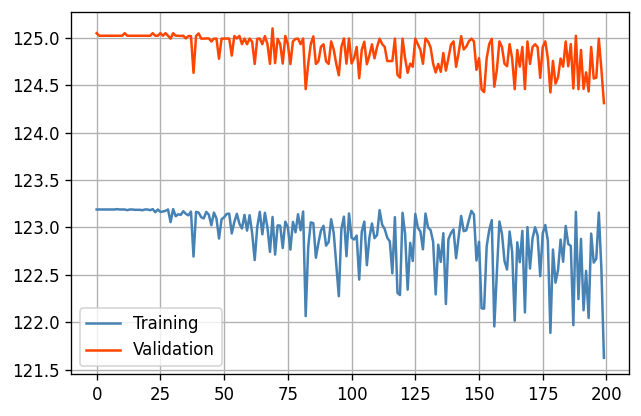

In [ ]:
# TRAINING VISUALIZATION

fig, ax = plt.subplots(dpi=120)

ax.plot(train_accs, c="steelblue", label="Training")
ax.plot(val_accs, c="orangered", label="Validation")
ax.grid()
ax.legend()

plt.show()

As multiple papers pointed out ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), applying **neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures**.
An alternative formulation ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)) omits neighborhood normalization completely and adds a simple skip-connection to the GNN layer in order to preserve central node information:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
with torch.no_grad():
    model.eval()

    y_pred = torch.cat(
        [model(batch.to(device)) for batch in tqdm(loader_te)]
    )

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
y_pred

tensor([[-2.1410e-03, -6.1476e+00],
        [-9.7667e-03, -4.6337e+00],
        [-7.2614e-02, -2.6587e+00],
        ...,
        [-3.4323e-02, -3.3891e+00],
        [-6.9137e-02, -2.7060e+00],
        [-5.7012e-03, -5.1699e+00]])

In [ ]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = "ogbg-molhiv")
print(evaluator.expected_input_format) 
print(evaluator.expected_output_format)  

==== Expected input format of Evaluator for ogbg-molhiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_graph, num_task)
- y_pred: numpy ndarray or torch tensor of shape (num_graph, num_task)
where y_pred stores score values (for computing AUC score),
num_task is 1, and each row corresponds to one graph.
nan values in y_true are ignored during evaluation.

==== Expected output format of Evaluator for ogbg-molhiv
{'rocauc': rocauc}
- rocauc (float): ROC-AUC score averaged across 1 task(s)



In [ ]:
# In most cases, input_dict is
y_true = torch.cat(
    [batch.y for batch in loader_te]
)
input_dict = {
    "y_true": y_true,
    #"y_pred": torch.stack([y_pred[i, correct] for i, correct in enumerate(y_true)])
    "y_pred": y_pred.argmax(dim=1).reshape((-1,1))
}

result_dict = evaluator.eval(input_dict)

In [ ]:
result_dict

{'rocauc': 0.5859508681125554}

In [ ]:
cm = confusion_matrix(y_true.flatten(), y_pred.argmax(dim=1))
print(f"""
Confusion matrix:
{cm}

Accuracy: {
    ((y_true.flatten() == y_pred.argmax(dim=1)).sum() / len(y_pred)).item()
}
""")


Confusion matrix:
[[3963   20]
 [ 107   23]]

Accuracy: 0.9691222906112671



In [ ]:
print(f"Negative samples : {(1 - y_true).sum().item()}, Positive samples : {y_true.sum().item()}")

Negative samples : 3983, Positive samples : 130
